# Portfolio Using Single Index Model  

## Importing Libraries

In [36]:
import pandas as pd
import numpy as np
import missingno as msno
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Step 1: Determining Market and Asset Alphas and Betas

### Dataset import

In [37]:
#constants
t_bill = pd.read_csv('./t-bill.csv')
t_bill['T-bill'] = t_bill['T-bill']/100
t_bill = t_bill.set_index(pd.to_datetime(t_bill['Year'], format='%Y')).drop('Year', axis=1)
risk_free = t_bill.mean().values[0]
risk_free

0.06081109423

In [38]:
#datasets
df = pd.read_csv('./stocks-pivoted-dataframe.csv').fillna(method="ffill")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
symbols = df.columns.unique().values
df.head()

,00DS30,00DSEGEN,00DSES,00DSEX,01.Bank,02.Cement,03.Ceramics_Sector,04.Engineering,05.Financial_Institutions,06.Food_&_Allied,...,VAMLBDMF1,VAMLRBBF,VFSTDL,WATACHEM,WMSHIPYARD,WONDERTOYS,YPL,ZAHEENSPIN,ZAHINTEX,ZEALBANGLA
date,,,,,,,,,,,,,,,,,,,,,
1999-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,74.50,NaN,NaN,NaN,10.1
1999-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,72.75,NaN,NaN,NaN,10.2
1999-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,73.50,NaN,NaN,NaN,10.4
1999-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,73.25,NaN,NaN,NaN,10.4
1999-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,72.75,NaN,NaN,NaN,10.3


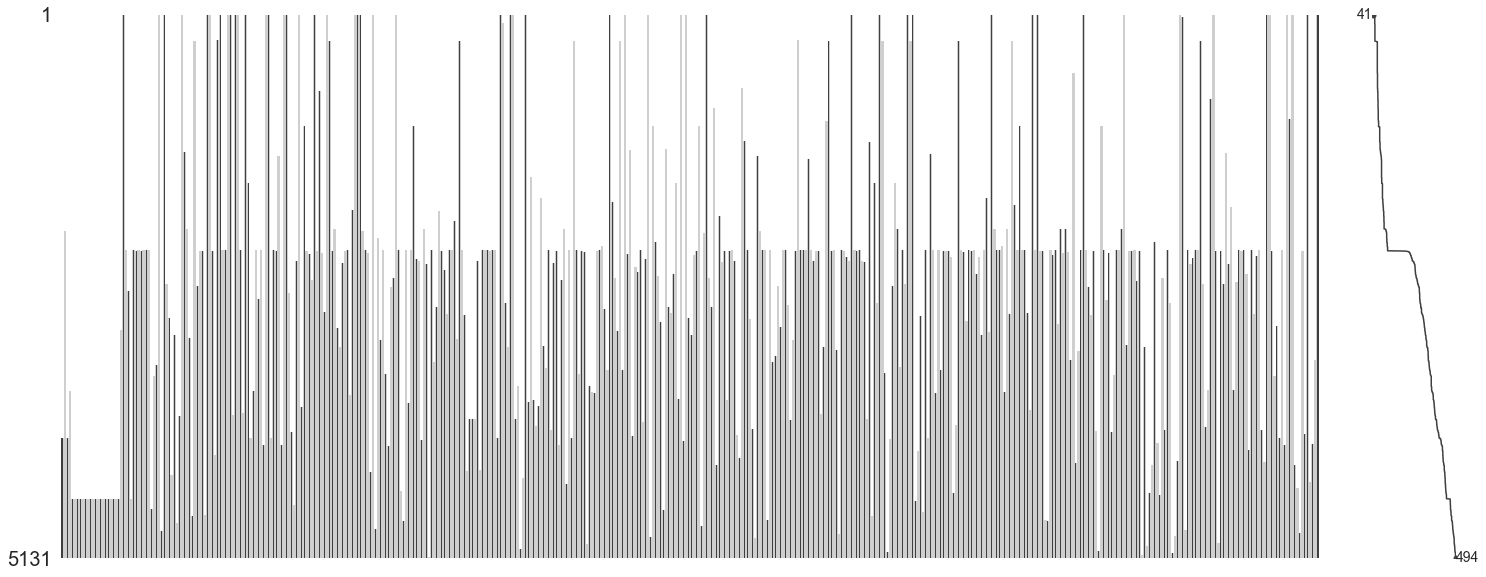

In [39]:
msno.matrix(df)

In [40]:
symbols

array(['00DS30', '00DSEGEN', '00DSES', '00DSEX', '01.Bank', '02.Cement',
       '03.Ceramics_Sector', '04.Engineering',
       '05.Financial_Institutions', '06.Food_&_Allied', '07.Fuel_&_Power',
       '08.Insurance', '09.IT_Sector', '10.Jute', '11.Miscellaneous',
       '12.Mutual_Funds', '13.Paper_&_Printing',
       '14.Pharmaceuticals_&_Chemicals', '15.Services_&_Real_Estate',
       '16.Tannery_Industries', '17.Telecommunication', '18.Textile',
       '19.Travel_&_Leisure', '1JANATAMF', '1STBSRS', '1STICB',
       '1STPRIMFMF', '20.Bond', '2NDICB', '3RDICB', '4THICB', '5THICB',
       '6THICB', '7THICB', '8THICB', 'AAMRANET', 'AAMRATECH', 'ABB1STMF',
       'ABBANK', 'ACFL', 'ACI', 'ACIFORMULA', 'ACIZCBOND', 'ACMELAB',
       'ACTIVEFINE', 'ADVENT', 'AFCAGRO', 'AFTABAUTO', 'AGNISYSL',
       'AGRANINS', 'AIBL1STIMF', 'AIL', 'AIMS1STMF', 'AL-HAJTEX',
       'ALAMINCHEM', 'ALARABANK', 'ALIF', 'ALLTEX', 'ALPHATOBA',
       'AMAMSEAFD', 'AMANFEED', 'AMBEEPHA', 'AMCL(PRAN)', 'ANLIMAYAR

['00DS30', '00DSEGEN', '00DSES', '00DSEX','DSEX','DS30']

In [41]:
biswa_df = df.loc[:, ['DSEX', 'BERGERPBL', 'FORTUNE' ]].dropna()
biswa_df['DSEX'] = biswa_df.DSEX.resample('M').mean()
biswa_df['BERGERPBL'] = biswa_df.BERGERPBL.resample('M').mean()
biswa_df['FORTUNE'] = biswa_df.FORTUNE.resample('M').mean()
biswa_df = biswa_df.dropna()
biswa_df.to_clipboard()

### Asset Selection for alphas and betas

In [42]:
selected_symbol = ['ZEALBANGLA', 'MONNOSTAF', 'DSEX', 'DS30']
df_selected = df.loc[:,selected_symbol].dropna()
df_selected_rate = df_selected.pct_change(1)
df_selected_rate

,ZEALBANGLA,MONNOSTAF,DSEX,DS30
date,,,,
2014-04-01,NaN,NaN,NaN,NaN
2014-04-02,-0.063063,-0.009158,0.015213,0.017300
2014-04-03,-0.076923,-0.042718,0.005531,0.014364
2014-04-06,0.041667,-0.007307,-0.007020,-0.006029
2014-04-07,-0.060000,-0.031546,0.004249,0.013355
...,...,...,...,...
2019-08-25,0.000000,-0.058977,-0.002505,-0.004454
2019-08-26,0.078788,-0.010034,-0.011096,-0.011999
2019-08-27,-0.087079,0.062476,0.002503,0.005204


In [9]:
df_selected_rate = df_selected_rate.dropna() - (risk_free/252)
df_selected_rate

,ZEALBANGLA,MONNOSTAF,DSEX,DS30
date,,,,
2014-04-02,-0.063304,-0.009400,0.014972,0.017059
2014-04-03,-0.077164,-0.042959,0.005290,0.014122
2014-04-06,0.041425,-0.007548,-0.007261,-0.006271
2014-04-07,-0.060241,-0.031787,0.004008,0.013113
2014-04-08,-0.042795,-0.033086,-0.004881,-0.000342
...,...,...,...,...
2019-08-25,-0.000241,-0.059218,-0.002747,-0.004695
2019-08-26,0.078547,-0.010275,-0.011337,-0.012241
2019-08-27,-0.087320,0.062235,0.002262,0.004963


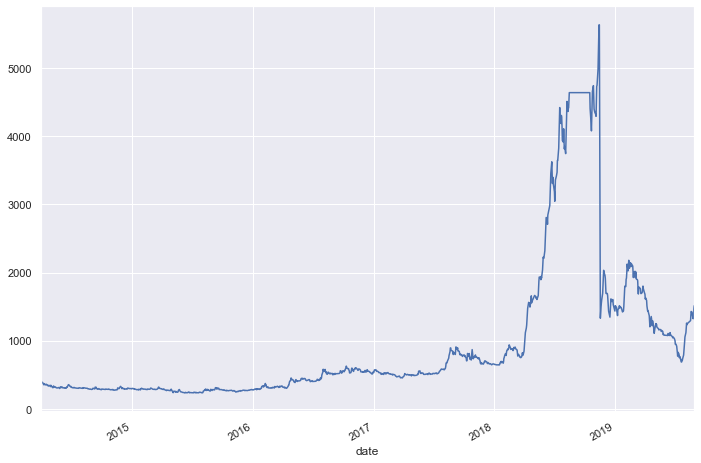

In [72]:
df_selected['MONNOSTAF'].plot()

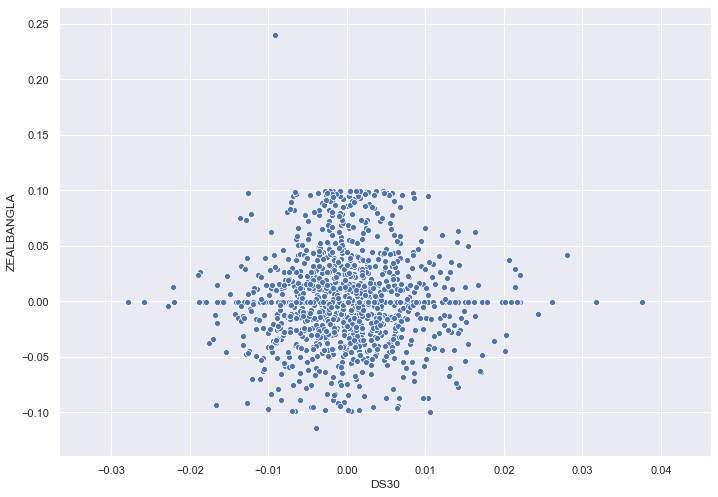

In [11]:
sns.scatterplot(df_selected_rate['DS30'], df_selected_rate['ZEALBANGLA'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ZEALBANGLA   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.501
Date:                Thu, 17 Oct 2019   Prob (F-statistic):              0.221
Time:                        13:02:07   Log-Likelihood:                 2370.4
No. Observations:                1307   AIC:                            -4737.
Df Residuals:                    1305   BIC:                            -4726.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.265      0.206      -0.001       0.004
DSEX           0.1980      0.162      1.225      0.221      -0.119       0.515
==============================================================================
Omnibus:                       82.836   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.847
Skew:                           0.441   Prob(JB):                     1.44e-34
Kurtosis:                       4.443   Cond. No.                         148.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

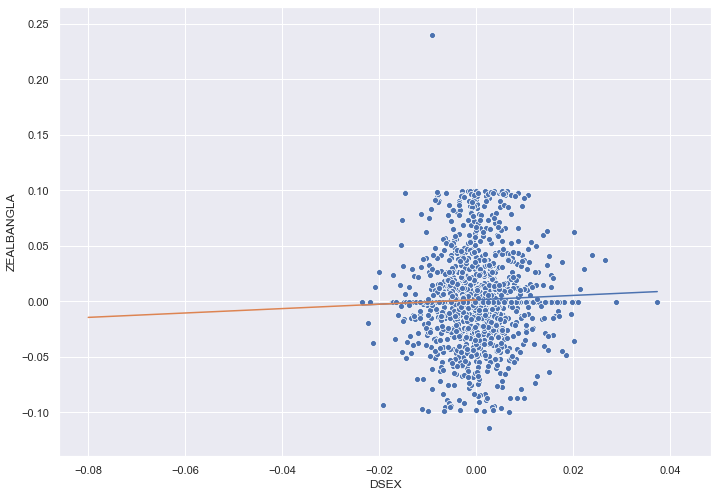

In [15]:
x = df_selected_rate['DSEX']
X = sm.add_constant(x)
Y = df_selected_rate['ZEALBANGLA']
model = sm.OLS(Y,X).fit()

predictions = model.predict(X)
sns.scatterplot(df_selected_rate['DSEX'], df_selected_rate['ZEALBANGLA'])
sns.lineplot(x, predictions)
x_line = np.arange(-.08,.01, .01)
y_line = model.params[0] + model.params[1]*x_line
sns.lineplot(x_line, y_line)
model.summary()

In [73]:
beta_df = pd.DataFrame()
columns_values =  np.delete(df.columns.values, np.where(df.columns.values == 'DSEX'))
for symbol in columns_values:
    df_reg = df.loc[:, ['DSEX', symbol]].pct_change(1).dropna()
    data_size = len(df_reg.index)
    market_premium_simple = (df_reg['DSEX'].mean() * 252) - risk_free
    market_premium_compound = (df_reg['DSEX'].apply(lambda x: x +1).cumprod().iloc[-1])**(252/data_size) - 1
    market_var = (df_reg['DSEX'].var() * 252 )
    symbol_var = (df_reg[symbol].var() * 252 )
    df_reg = df_reg - ((1 + risk_free)**(1/252) -1)
    x = df_reg.loc[:,'DSEX']
    X = sm.add_constant(x)
    Y = df_reg.loc[:,symbol]
    model = sm.OLS(Y,X).fit()
    beta_df = beta_df.append({'symbol':symbol, 
                              'Data Length': data_size,
                              'Alpha': model.params[0], 
                              'Beta': model.params[1], 
                              'R Squared': model.rsquared, 
                              'R Squared Adj': model.rsquared_adj, 
                              'Regression Variance': (model.ess/data_size) * 252, 
                              'Residual Variance': (model.ssr / data_size) * 252,
                              'Total Variance': (model.centered_tss / data_size) * 252,
                             'Market Premium S': market_premium_simple, 
                              'Market Premium C': market_premium_compound,
                              'Market Variance': market_var, 
                              'Symbol Variance': symbol_var 
                                 }, ignore_index=True)
    
beta_df = beta_df.set_index('symbol')
beta_df.to_csv('./alphas-betas-assets.csv')

In [74]:
round(beta_df, 3)

,Alpha,Beta,Data Length,Market Premium C,Market Premium S,Market Variance,R Squared,R Squared Adj,Regression Variance,Residual Variance,Symbol Variance,Total Variance
symbol,,,,,,,,,,,,
00DS30,-0.000,0.938,1129.0,0.007,-0.048,0.011,0.857,0.857,0.010,0.002,0.011,0.011
00DSEGEN,-0.000,-0.000,1307.0,0.023,-0.032,0.012,-inf,-inf,-0.000,0.000,0.000,0.000
00DSES,-0.000,0.852,1129.0,0.007,-0.048,0.011,0.819,0.819,0.008,0.002,0.010,0.010
00DSEX,0.000,1.000,1307.0,0.023,-0.032,0.012,1.000,1.000,0.012,0.000,0.012,0.012
01.Bank,0.000,1.487,560.0,-0.035,-0.091,0.011,0.189,0.188,0.024,0.103,0.127,0.127
...,...,...,...,...,...,...,...,...,...,...,...,...
WONDERTOYS,-0.000,-0.000,1307.0,0.023,-0.032,0.012,-inf,-inf,-0.000,0.000,0.000,0.000
YPL,-0.001,1.571,712.0,0.032,-0.024,0.011,0.151,0.150,0.026,0.146,0.172,0.172
ZAHEENSPIN,-0.001,1.283,1072.0,0.029,-0.027,0.011,0.099,0.098,0.018,0.163,0.181,0.181


```np.delete(df.columns.values, np.where(df.columns.values == 'DSEX'))
```
